<a href="https://colab.research.google.com/github/UsernameLucky/Machine_Learning-projects/blob/main/Encoder_Decoder_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model, Sequence

import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
# set parameter values
BATCH_SIZE = 32
EPOCHS = 10
LSTM_NODES = 256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

# too short sentences
NUM_SHORT = 2

In [ ]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0

for line in open(r'UN_devset_french.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    line = line.replace("\n","")
    input_sentences.append(line)

for line in open(r'UN_devset_english.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    line = line.replace("\n","")

    output_sentence = line + ' <eos>'
    output_sentence_input = '<sos> ' + line

    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

In [ ]:
len(output_sentences), len(output_sentences_inputs), len(input_sentences)

(4000, 4000, 4000)

In [ ]:
# print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists:
print(input_sentences[33])
print(output_sentences[33])
print(output_sentences_inputs[33])

3 décembre
3 December <eos>
<sos> 3 December


In [ ]:
#input sequence tokenisation
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

In [ ]:
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

Total unique words in the input: 11310


In [ ]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Length of longest sentence in input: 113


In [ ]:
# Output sequence tokenization
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [ ]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 13097


In [ ]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 80


### Padding

In [ ]:
# defines the encoder input dimension
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)

encoder_input_sequences.shape: (4000, 113)


In [ ]:
print("encoder_input_sequences[33]:", encoder_input_sequences[33])

encoder_input_sequences[33]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 102 205]


In [ ]:
# verify that the integer values for some examples
print(word2idx_inputs["décembre"])
print(word2idx_inputs["3"])

205
102


In [ ]:
# define the decoders input dimension
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)

decoder_input_sequences.shape: (4000, 80)


In [ ]:
print("decoder_input_sequences[33]:", decoder_input_sequences[33])

decoder_input_sequences[33]: [  7 280 204   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [ ]:
# print the corresponding integers from the word2idx_outputs dictionary,
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["i"])
print(word2idx_outputs["am"])
print(word2idx_outputs["seek"])

7
73
1327
886


### Word embedding

In [ ]:
embeddings_dictionary = dict()

glove_file = r'glove.6B.100d.txt'
glove_file = open(glove_file, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
num_words_outputs = min(MAX_NUM_WORDS, len(word2idx_outputs) + 1)
embedding_matrix = np.zeros((num_words_outputs, EMBEDDING_SIZE))
for word, index in word2idx_outputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(13098, 100)

In [ ]:
# print embedding of the
print(embeddings_dictionary["the"])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [ ]:
## MODEL

In [ ]:
# create the embedding layer for the INPUT (FRENCH)
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_layer = Embedding(num_words, LSTM_NODES)

In [ ]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [ ]:
# print shape of decoder
decoder_targets_one_hot.shape

(4000, 80, 13098)

In [ ]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [ ]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [ ]:
# Create the encoder and decoders.
# The input to the encoder will be the sentence in FRENCH and the output will be the hidden state and cell state of the LSTM
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
# The next step is to define the decoder.
# The decoder will have two inputs:
#   the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.
decoder_inputs_placeholder = Input(shape=(max_out_len,))



decoder_embedding = Embedding(num_words_output,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=max_out_len)
# Embedding(num_words_output, LSTM_NODES)

decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
# Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# compile the model:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

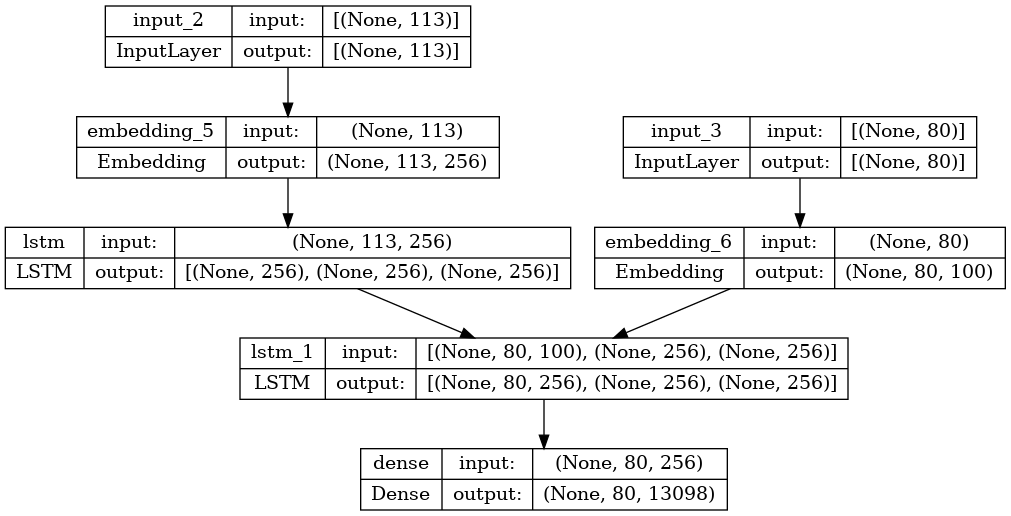

In [ ]:
# plot our model :
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit the model: disable GPU to run on cpu only
# comment on colab
with tf.device('/cpu:0'):
    r = model.fit(
        [encoder_input_sequences, decoder_input_sequences],
        decoder_targets_one_hot,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )

Epoch 1/4
113/113 [==============================] - 234s 2s/step - loss: 3.1213 - accuracy: 0.6617 - val_loss: 2.4420 - val_accuracy: 0.6806
Epoch 2/4
113/113 [==============================] - 254s 2s/step - loss: 2.3376 - accuracy: 0.6940 - val_loss: 2.3718 - val_accuracy: 0.6998
Epoch 3/4
113/113 [==============================] - 228s 2s/step - loss: 2.2762 - accuracy: 0.7051 - val_loss: 2.3327 - val_accuracy: 0.7026
Epoch 4/4
113/113 [==============================] - 191s 2s/step - loss: 2.2410 - accuracy: 0.7082 - val_loss: 2.3082 - val_accuracy: 0.7048


In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

# Since now at each step we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell states as shown below:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
# Now at each time step, there will be only single word in the decoder input, we need to modify the decoder embedding layer as follows:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
# Next, we need to create the placeholder for decoder outputs:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
# To make predictions, the decoder output is passed through the dense layer:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# The final step is to define the updated decoder model, as shown here:

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

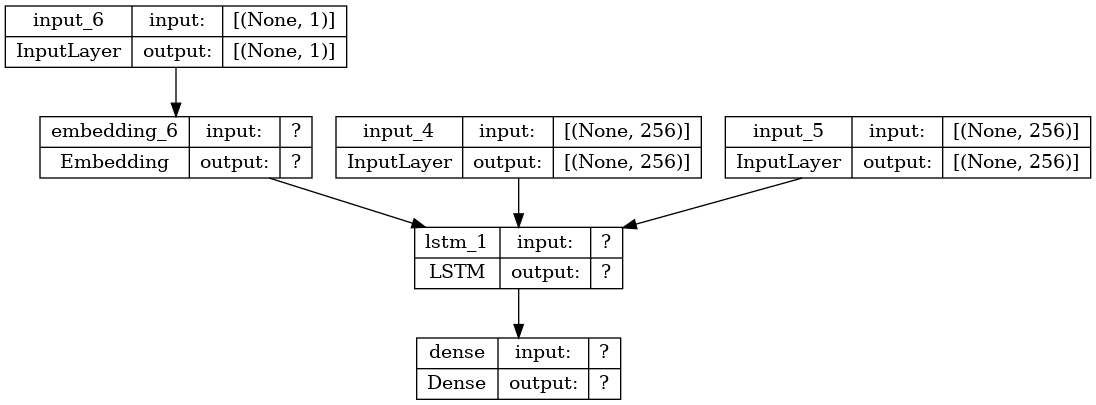

In [ ]:
# Let's now plot our modified decoder LSTM that makes predictions:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)


In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)

1/1 [==============================] - 0s 22ms/step


In [ ]:
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: D'éminents dirigeants autochtones ont été invités à prendre la parole à cette occasion et à participer à divers ateliers et à y intervenir.
Response: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
